## 4.5 GBM

### GBM의 개요 및 실습

In [ ]:
import pandas as pd
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/content/drive/MyDrive/human_activity/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/human_activity/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('/content/drive/MyDrive/human_activity/human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/human_activity/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/human_activity/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1048.1 초


In [ ]:
import xgboost
print(xgboost.__version__)

1.7.6


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [ ]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {
    'max_depth':3,
    'eta':0.05,
    'objective':'binary:logistic',
    'eval_metric':'logloss'
}
num_rounds = 400

In [ ]:
eval_list = [(dtr, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, early_stopping_rounds=100, evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(f'예측값 10개만 표시: {preds[:10]}')

predict() 수행 결과값을 10개만 표시
[0.918 0.006 0.675 0.049 0.987 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# 저번에 생성한 get_clf_eval() 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC:0.9465


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

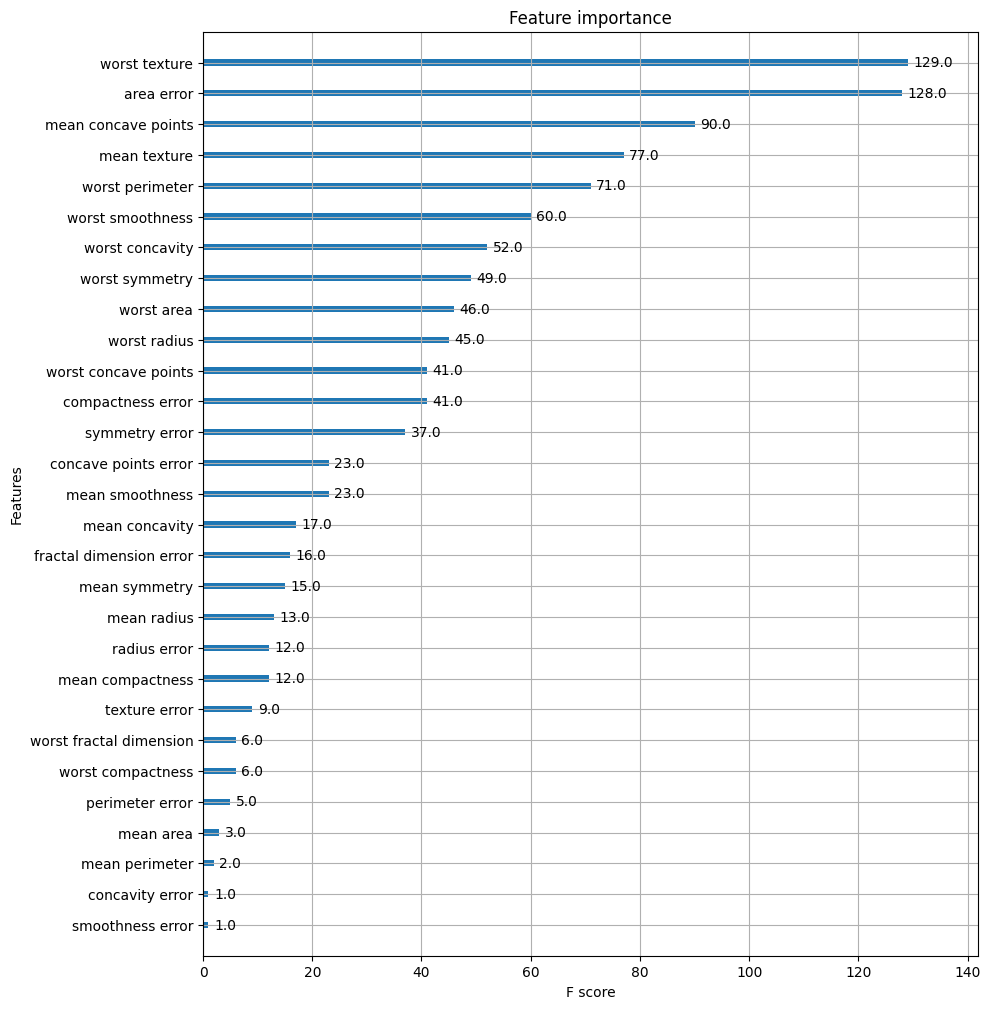

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC:0.9530


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals=[(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [ ]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC:0.9465


In [ ]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

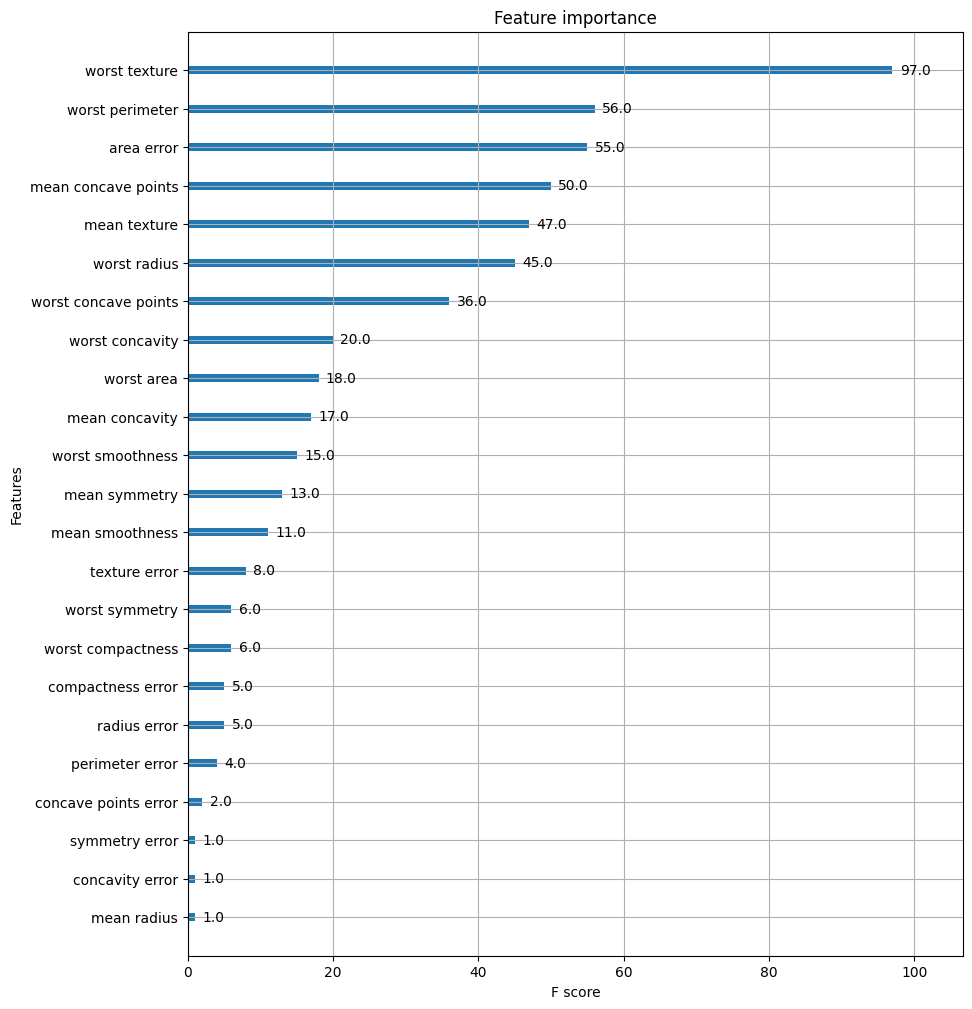

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)

### LightGBM - 위스콘신 유방암 예측

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC:0.9465


### 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

In [ ]:
pip install hyperopt

In [ ]:
from hyperopt import hp

search_space = {'x':hp.quniform('x', -10, 10, 1), 'y':hp.quniform('y', -15, 15, 1)}

In [ ]:
from hyperopt import STATUS_OK

# 목적함수
def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval = x**2 - 20*y

  return retval

In [ ]:
from hyperopt import fmin, tpe, Trials
import numpy as np

## 입력 결과를 저장할 객체 생성
trial_val = Trials()

## 목적 함수의 최솟값을 반환하는 최적 입력 변수를 5번 시도로 찾아냄
## fmin() 함수는 아래의 주요 인자를 가짐
best_01 = fmin(fn=objective_func,    ## 목적 함수
               space=search_space,   ## 검색 공간
               algo=tpe.suggest,     ## 베이지안 최적화 적용 알고리즘
               max_evals=20,         ## 입력 시도 횟수
               trials=trial_val,     ## 시도한 입력 값 및 입력 결과 저장
               #rstate=np.random.default_rng(seed=0)   ## fmin()을 시도할 때마다 동일한 결과를 가질 수 있도록 설정하는 랜덤 시드
               )
print('best:', best_01)

100%|██████████| 20/20 [00:00<00:00, 733.21trial/s, best loss: -279.0]
best: {'x': -1.0, 'y': 14.0}


In [ ]:
trial_val = Trials()

#max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 356.61trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [ ]:
print(trial_val.results)
print(trial_val.vals)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]
{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [ ]:
## trial_val을 dataframe 형태로 변환하여 확인
import pandas as pd

losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame(
    {
        'x':trial_val.vals['x'],
        'y':trial_val.vals['y'],
        'losses':losses
     }
)

result_df.head(5)

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0


### HyperOpt을 사용하여 XGBoost 하이퍼 파라미터 튜닝하기

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

## 유방암 데이터셋 로드
dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

## 데이터를 Pandas DataFrame으로 로드
cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
## 학습 및 검증 데이터셋으로 데이터 분리
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [ ]:
## 학습, 검증용 데이터셋 비율 8 : 2
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

## X_train, y_train을 다시 9 : 1 비율로 분리
## => XGBoost가 제공하는 교차 검증 성능 평가 및 조기 중단을 수행하기 위함
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [ ]:
## 모델 성능 평가 함수 선언
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
## 1. 검색 공간 설정

from hyperopt import hp

xgb_search_space = {
    'max_depth':hp.quniform('max_depth', 5, 20, 1),                     ## 정수형 하이퍼 파라미터 => quniform 사용
    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),        ## 정수형 하이퍼 파라미터 => quniform 사용
    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1),
}

In [ ]:
## 2. 목적 함수 설정
## 검색 공간에서 설정한 하이퍼 파라미터들을 입력 받아서 XGBoost를 학습시키고, 평가 지표를 반환하도록 구성되어야 함

from sklearn.model_selection import cross_val_score  ## 교차 검증
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):

  xgb_clf = XGBClassifier(
      n_estimators=100,
      max_depth=int(search_space['max_depth']),                ## int형으로 형변환 필요
      min_child_weight=int(search_space['min_child_weight']),  ## int형으로 형변환 필요
      learning_rate=search_space['learning_rate'],
      colsample_bytree=search_space['colsample_bytree'],
      eval_metric='logloss'
  )

  accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)  ## 3개의 교차 검증 세트로 정확도 반환

  ## acc는 cv=3 개수만큼의 결과를 리스트로 가짐, 이를 평균하여 반환하되, -1을 곱함
  return {
      'loss':(-1) * np.mean(accuracy),
      'status':STATUS_OK
  }

In [ ]:
## 3. fmin()을 사용하여 최적 하이퍼 파라미터 찾기

from hyperopt import fmin, tpe, Trials

trial_val = Trials() ## 결과 저장

best = fmin(
    fn=objective_func,
    space=xgb_search_space,
    algo=tpe.suggest,
    max_evals=50,    ## 최대 반복 횟수 지정
    trials=trial_val,
)
print('best:', best)

100%|██████████| 50/50 [00:17<00:00,  2.88trial/s, best loss: -0.9692691994887882]
best: {'colsample_bytree': 0.5078640178056508, 'learning_rate': 0.129169132861837, 'max_depth': 11.0, 'min_child_weight': 2.0}


In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(round(best['colsample_bytree'], 5), round(best['learning_rate'], 5), int(best['max_depth']), int(best['min_child_weight'])))


colsample_bytree:0.50786, learning_rate:0.12917, max_depth:11, min_child_weight:2


In [ ]:
## 획득한 최적의 하이퍼 파라미터를 이용하여 모델 선언

xgb_wrapper = XGBClassifier(
    n_estimators=400,
    learning_rate=round(best['learning_rate'], 5),
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    colsample_bytree=round(best['colsample_bytree'], 5)
)
## early stopping

evals = [(X_tr, y_tr), (X_val, y_val)]

## model train

xgb_wrapper.fit(
    X_tr, y_tr,
    early_stopping_rounds=50,
    eval_metric='logloss',
    eval_set=evals,
    verbose=True
)
## eval

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.58880	validation_1-logloss:0.61024
[1]	validation_0-logloss:0.50713	validation_1-logloss:0.54402
[2]	validation_0-logloss:0.44089	validation_1-logloss:0.49532
[3]	validation_0-logloss:0.38764	validation_1-logloss:0.45828
[4]	validation_0-logloss:0.34094	validation_1-logloss:0.42690
[5]	validation_0-logloss:0.30150	validation_1-logloss:0.40208
[6]	validation_0-logloss:0.26897	validation_1-logloss:0.38690
[7]	validation_0-logloss:0.24061	validation_1-logloss:0.37032
[8]	validation_0-logloss:0.21545	validation_1-logloss:0.35330
[9]	validation_0-logloss:0.19437	validation_1-logloss:0.34052
[10]	validation_0-logloss:0.17624	validation_1-logloss:0.32572
[11]	validation_0-logloss:0.16061	validation_1-logloss:0.31502
[12]	validation_0-logloss:0.14707	validation_1-logloss:0.30774
[13]	validation_0-logloss:0.13521	validation_1-logloss:0.29994
[14]	validation_0-logloss:0.12456	validation_1-logloss:0.29756
[15]	validation_0-logloss:0.11594	validation_1-logloss:0.29651
[1

## 4.11 스태킹 앙상블

### 기본 스태킹 모델

In [1]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [3]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression()

In [4]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [5]:
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [6]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [8]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


### CV 세트 기반의 스태킹

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean

In [10]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [11]:
# concatenate는 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐주는 기능을 제공
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print(f'원본 학습 피처 데이터 shape: {X_train.shape}, 원본 테스트 피처 shape: {X_test.shape}')
print(f'스태킹 학습 피처 데이터 shape: {Stack_final_X_train.shape}, 스태킹 테스트 피처 데이터 shape: {Stack_final_X_test.shape}')

원본 학습 피처 데이터 shape: (455, 30), 원본 테스트 피처 shape: (114, 30)
스태킹 학습 피처 데이터 shape: (455, 4), 스태킹 테스트 피처 데이터 shape: (114, 4)


In [14]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
